In [5]:
import os
import hashlib
import numpy as np
from glob import glob
from random import shuffle
from keras import optimizers
from skimage.color import gray2rgb
from scipy.misc import imread, imsave
from keras.applications import InceptionV3
from keras.models import Model, Sequential
from keras.layers.core import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard

# Stop training if validation loss doesn't improve for 10 epochs
earlystop = EarlyStopping(monitor = "val_loss", 
                          patience = 10, 
                          verbose = 1, 
                          mode = "auto")

# Save the best model after every epoch
checkpoint = ModelCheckpoint(filepath = "inceptionv3.hdf5", 
                             verbose = 1, 
                             save_best_only = True)

# Reduce the learning rate after validation loss plateaus
reducelr = ReduceLROnPlateau(monitor = "val_loss", 
                             factor = 0.2,
                             patience = 5)

TARGET_SIZE = (299, 299) # Input shape for Inception v3
BATCH_SIZE = 32 # Batch size for training



Using TensorFlow backend.


In [0]:
def clean_train(train_folder):
    '''Removes duplicates in train folder where the same images appears in
    more than one class'''
    hashes = {}
    labels = {}

    print("computing md5 of training data")

    for fname in glob(train_folder+"/*/*.jpg"):
        labels[fname] = fname.split("//")[-2]
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()  
        if h in hashes:
            hashes[h].append(fname)
        else:
            hashes[h] = [fname]
    
    # Find duplicates
    repeated = sum(1 for k,v in hashes.items() if len(v) > 1 )
    print("Files appearing more than once in train: ", repeated)
    
    del_files = []
    
    # Find duplicate images with different class names
    for k,v in hashes.items():
        if len(v) > 1:
            c = set([labels[x] for x in v])
            if len(c) > 1:
                del_files = del_files.append(v)
    
    for x in del_files:
        os.remove(x)

    print(len(del_files), "images deleted from training set")

In [0]:
def process_test_images(test_folder):
    ''' Function to convert test images to 3 channels (for images having
    4 channels or less than 3 channels)
    Convert from 4 channel inputs like : CMYK and Alpha to 3 channels'''
    for img in os.listdir(test_folder):
        img_path = os.path.join(test_folder, img)
        img_file = imread(img_path)
        if len(img_file.shape) < 3:
            img_file = gray2rgb(img_file)
            img_file = img_file.astype(np.float32, copy = False)
            imsave(img_path, img_file)
        if len(img_file.shape) == 4:
            img_file = img_file[:,:,:-1]
            img_file = img_file.astype(np.float32, copy = False)
            imsave(img_path, img_file)

In [0]:
def find_leak(train_folder, test_folder):
    '''Finds images present in both training and test set'''

    hashes = {}
    labels = {}

    print("computing md5 of training data")

    for fname in glob(train_folder+"/*/*.jpg"):
        labels[fname] = fname.split("//")[-2]
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()  
        if h in hashes:
            hashes[h].append(fname)
        else:
            hashes[h] = [fname]

    print("comparing training and test set")
    
    leaks = []
    for fname in glob(test_folder+"/*.jpg"):
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()
        if h in hashes:
            leaks.append((fname.split("//")[-1],hashes[h][0].split("//")[-2]))

    print("Number of test images present in train:{}".format(len(leaks)))
    return leaks

In [0]:
def process_train_images(train_folder):
    ''' Function to convert training images to 3 channels (for images having
    4 channels or less than 3 channels)''' 
    
    classes = os.listdir(train_folder)
    for cla in classes:
        cla_path = os.path.join("dataset", "train", cla)
        for img in os.listdir(cla_path):
            img_path = os.path.join("dataset", "train", cla, img)
            img_file = imread(img_path)
            if len(img_file.shape) < 3:
                img_file = gray2rgb(img_file)
                img_file = img_file.astype(np.float32, copy = False)
                imsave(img_path, img_file)
            if len(img_file.shape) == 4:
                img_file = img_file[:,:,:-1]
                img_file = img_file.astype(np.float32, copy = False)
                imsave(img_path, img_file)
                

In [0]:
def create_val_set(val_size):
    '''Function to create a validation set from training images'''
    if not os.path.exists("dataset//valid"):
        os.makedirs("dataset//valid")
    class_list = os.listdir("dataset//train")
    for cla in class_list:
        if os.path.exists(os.path.join("dataset", "valid", cla)):
            if len(os.listdir(os.path.join("dataset", "valid", cla))) == 0:
                new_files = os.listdir(os.path.join("dataset", "train", cla))
                new_files = remove_percentage(new_files, val_size)
                for nf in new_files:
                    os.rename(os.path.join("dataset", "train", cla, nf), 
                              os.path.join("dataset", "valid", cla, nf))
            else:
                new_files = os.listdir(os.path.join("dataset", "valid", cla))
                for nf in new_files:
                    os.rename(os.path.join("dataset", "valid", cla, nf),
                              os.path.join("dataset", "train", cla, nf))
                new_files = os.listdir(os.path.join("dataset", "train", cla))
                new_files = remove_percentage(new_files, val_size)
                for nf in new_files:
                    os.rename(os.path.join("dataset", "train", cla, nf), 
                              os.path.join("dataset", "valid", cla, nf))
        else:
            os.makedirs(os.path.join("dataset", "valid", cla))
            new_files = os.listdir(os.path.join("dataset", "train", cla))
            new_files = remove_percentage(new_files, val_size)
            for nf in new_files:
                os.rename(os.path.join("dataset", "train", cla, nf), 
                          os.path.join("dataset", "valid", cla, nf))

In [0]:
# Pre-processing function for Inception v3 model
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def remove_percentage(list_a, percentage):
    ''' Function to randomly pick x percentage from a list'''
    shuffle(list_a)
    count = int(len(list_a) * percentage)
    if not count: 
        return []
    list_a[-count:], list_b = [], list_a[-count:]
    return list_b

In [0]:
def define_model():
    ''' Load a pre-trained inception V3 model and change the top layers to 
    match the number of classes of our problem'''
    base_model = InceptionV3(weights = "imagenet", 
                         include_top = False, 
                         input_shape = (299, 299, 3))
    base_model.layers.pop()
    for i in range(len(base_model.layers)):
        base_model.layers[i].trainable = False
    add_model = Sequential()
    add_model.add(Flatten(input_shape = base_model.output_shape[1:]))
    add_model.add(Dense(256, activation = "relu"))
    add_model.add(Dense(len(os.listdir("dataset//train")), activation="softmax"))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9),
              metrics = ["accuracy"])
    model.summary()
    return(model)

# UFFF ENOUGH OF FUNCTIONS 

In [13]:
! pip install psutil

In [14]:
! pip install keras==2.1.4

In [0]:
!pip install -U -q PyDrive

In [0]:
import keras
import psutil
import pandas as pd
import tensorflow as tf
from google.colab import auth
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [17]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file1 = drive.CreateFile({'id':'1Pqjs7c5MAgPQLiMA3YR8dFg_YHLnPdlO'})
file1.GetContentFile('dataset.zip')

In [20]:
!unzip dataset.zip -d ./

Archive:  dataset.zip
replace ./dataset/Superhero_Submission_Format.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
#file2 = drive.CreateFile({'id':'18H1VBB5It4tneouiOhTqSQjFscOomAum'})
#file2.GetContentFile('ernest.py')
#from ernest import *

Delete files appearing in more than one class in training set

In [22]:
clean_train("dataset//train")

computing md5 of training data
Files appearing more than once in train:  31
0 images deleted from training set


In [0]:

#Check whether any file appears in both training and test set

In [23]:
_ = find_leak("dataset//train", "dataset//test")

computing md5 of training data
comparing training and test set
Number of test images present in train:0


In [28]:
!ls

datalab  inceptionv3.hdf5  MyModelSummary
dataset  inceptionV3.json  Trsanfer_lr_withbase_inceptionV3.h5
Graph	 ModelSummary	   Trsanfer_lr_withbase_inceptionV3.json


In [0]:
#Convert all training images to 3 channels
process_train_images("dataset//train")

In [0]:
#Convert all test images to 3 channels
process_test_images("dataset//test//data")

In [0]:
create_val_set(0.2)

In [32]:
#Load the pre-trained Inception V3 model
model = define_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

                                                                 mixed9_0[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_85[0][0]              
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 8, 8, 448)    917504      mixed9[0][0]                     
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 8, 8, 448)    1344        conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 8, 8, 448)    0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv2d_87 

# VVI  Define data generators

In [0]:
train_datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        #,preprocessing_function = preprocess_input
)

test_datagen = ImageDataGenerator()
    #preprocessing_function = preprocess_input)

In [34]:
train_generator = train_datagen.flow_from_directory(
        "dataset//train",
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical")

Found 4350 images belonging to 12 classes.


In [35]:
validation_generator = train_datagen.flow_from_directory(
        "dataset//valid", 
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical")

Found 1083 images belonging to 12 classes.


In [36]:
test_generator = test_datagen.flow_from_directory(
        "dataset//test", 
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical", 
        shuffle = False)

Found 3375 images belonging to 1 classes.



Define callbacks

In [0]:
#!mkdir Graph|chmod 777 Graph
tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/Graph', histogram_freq=0, write_graph=True, write_images=True)

earlystop = EarlyStopping(monitor = "val_loss", 
                          patience = 10, 
                          verbose = 1, 
                          mode = "auto")

checkpoint = ModelCheckpoint(filepath = "inceptionv3.hdf5", 
                             verbose = 1, 
                             save_best_only = True)

reducelr = ReduceLROnPlateau(monitor = "val_loss", 
                             factor = 0.2,
                             patience = 2)


Fit the model

In [38]:

model.fit_generator(
        generator = train_generator,
        epochs = 5,
        callbacks = [checkpoint, earlystop, reducelr,tbCallBack],
        validation_data = validation_generator,
        verbose = 1)

Epoch 1/5
136/136 [==============================] - 151s 1s/step - loss: 2.2547 - acc: 0.2398 - val_loss: 13.1916 - val_acc: 0.1440

Epoch 00001: val_loss improved from inf to 13.19161, saving model to inceptionv3.hdf5
Epoch 2/5
136/136 [==============================] - 135s 996ms/step - loss: 1.8777 - acc: 0.3719 - val_loss: 13.6576 - val_acc: 0.0979

Epoch 00002: val_loss did not improve
Epoch 3/5
 91/136 [===================>..........] - ETA: 36s - loss: 1.6680 - acc: 0.4553136/136 [==============================] - 138s 1s/step - loss: 1.6616 - acc: 0.4551 - val_loss: 13.3850 - val_acc: 0.1200

Epoch 00003: val_loss did not improve
Epoch 4/5
136/136 [==============================] - 138s 1s/step - loss: 1.5327 - acc: 0.4929 - val_loss: 13.5545 - val_acc: 0.1210

Epoch 00004: val_loss did not improve
Epoch 5/5
136/136 [==============================] - 138s 1s/step - loss: 1.4435 - acc: 0.5239 - val_loss: 13.4625 - val_acc: 0.1154

Epoch 00005: val_loss did not improve


Predict on test set

In [40]:

predictions = model.predict_generator(
        test_generator,
        verbose = 1)

106/106 [==============================] - 51s 481ms/step


In [0]:
predictions = np.argmax(predictions, axis = 1)
labels = train_generator.class_indices
predictions = [list(labels.keys())[list(labels.values()).index(i)] for i in predictions]

In [42]:
predictions[1:10]

['Batman',
 'Black Panther',
 'Batman',
 'Hulk',
 'Batman',
 'Aquaman',
 'Batman',
 'Batman',
 'Superman']

Lime for model interpretability


In [43]:
!pip install lime
from lime import lime_image

In [0]:
img_file = imread('/content/dataset/test/data/superhero_test_1.jpg')

In [0]:
import tensorflow as ktf
img_file_s=ktf.image.resize_images(img_file,(299, 299))
img_file_s=tf.Session().run(img_file_s)
img_file_s=preprocess_input(img_file_s)

In [0]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img_file_s, model.predict, top_labels=20, hide_color=0, num_samples=100)

In [85]:
explanation.top_labels

[9, 1, 10, 4, 2, 5, 0, 8, 11, 7, 6, 3]

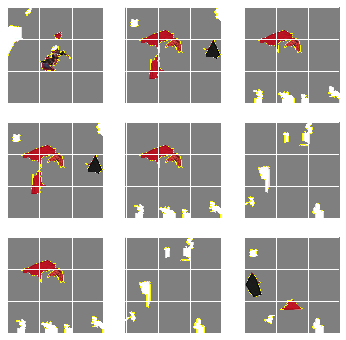

In [98]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import seaborn as sns

nb_rows = 3
nb_cols = 3
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

for i in range(0, nb_rows):
  for j in range(0, nb_cols):
    axs[i, j].xaxis.set_ticklabels([])
    axs[i, j].yaxis.set_ticklabels([])
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i+j], positive_only=True, num_features=5, hide_rest=True)
    axs[i,j].imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
#Save model object
json_model = model.to_json()
with open("Trsanfer_lr_withbase_inceptionV3.json", "w") as json_file:
    json_file.write(json_model)
    
model.save_weights("Trsanfer_lr_withbase_inceptionV3.h5")

In [0]:
#Save prediction file
new_subm = pd.DataFrame({"filename": test_generator.filenames, "Superhero": predictions})
new_subm["filename"] = new_subm["filename"].apply(lambda x: x.split("/")[1])
new_subm["filename"] = new_subm["filename"].apply(lambda x: x.split(".")[0])

In [44]:
file3 = drive.CreateFile({"title": "Trsanfer_lr_withbase_inceptionV3"})
file3.Upload()
print('title: %s, id: %s' % (file3['title'], file3['id']))

title: Trsanfer_lr_withbase_inceptionV3, id: 1SgWAJuylXro79y1sBRlEzt31YA34PU17


**Incremental learning Steps **

In [66]:
#we will use the google drive work as a local drive and save the model
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

In [72]:
# Create a directory 'MyModelSummary' and mount Google Drive using that directory.
!mkdir -p MyModelSummary
!google-drive-ocamlfuse MyModelSummary

#create a directory to save model summary in the mounted directory,this is where we save all the model specifications
#1.the architecture of the model, allowing to re-create the model
#2.the weights of the model
#3.the training configuration (loss, optimizer)
#4.the state of the optimizer, allowing to resume training exactly where you left off.
!mkdir /content/MyModelSummary/
!chmod 777 /content/MyModelSummary/

model.save('/content/MyModelSummary/ModelSummary/Trsanfer_lr_withbase_inceptionV3.h5')  # creates a HDF5 file 'my_model.h5'

#From the next time,just load the model with the below lines and continue with your model execution
from keras.models import load_model

# returns a compiled model,identical to the previous run
model_2 = load_model('/content/MyModelSummary/ModelSummary/Trsanfer_lr_withbase_inceptionV3.h5')
model_2.summary()

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
mkdir: cannot create directory ‘/content/MyModelSummary/’: File exists
chmod: changing permissions of '/content/MyModelSummary/': Input/output error
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
____________________________________________________________

mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8, 8, 768)    0           activation_83[0][0]              
                                                                 activation_84[0][0]              
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 8, 8, 192)    0           batch_normalization_85[0][0]     
__________________________________________________________________________________________________
mixed9 (Concatenate)            (None, 8, 8, 2048)   0           activation_77[0][0]              
                                                                 mixed9_0[0][0]                   
          